# Modelo XGBoost de predição de valores de combustíveis

In [1]:
# Importando bibliotecas iniciais
import pandas as pd
import numpy as np
import pyodbc
import json 

In [2]:
# Criando conexão com o banco de dados
server = 'beautyball\\SQLEXPRESS'  # Dupla barra invertida
database = 'mlet-desafio'

conexao = (
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={server};"
    f"DATABASE={database};"
    f"Trusted_Connection=yes;"
)

conn = pyodbc.connect(conexao)

cursor = conn.cursor()
 
query = """
SELECT * FROM dbo.PRECOS_COMBUSTIVEL
"""

df = pd.read_sql(query, conn)

C:\Users\maria\AppData\Local\Temp\ipykernel_15068\1389128851.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [3]:
# Explorando os dados
shape = df.shape 
colunas = df.columns
descricao = df.describe()

print(df.head())
print(f'Shape do DF: {shape}, \nColunas: {colunas}, \nDescrição dos dados:{descricao}')

  DATA INICIAL DATA FINAL            ESTADO       MUNICÍPIO           PRODUTO  \
0   2025-05-11 2025-05-17           SERGIPE         ARACAJU  ETANOL HIDRATADO   
1   2025-05-11 2025-05-17              PARA           BELEM  ETANOL HIDRATADO   
2   2025-05-11 2025-05-17      MINAS GERAIS  BELO HORIZONTE  ETANOL HIDRATADO   
3   2025-05-11 2025-05-17           RORAIMA       BOA VISTA  ETANOL HIDRATADO   
4   2025-05-11 2025-05-17  DISTRITO FEDERAL        BRASILIA  ETANOL HIDRATADO   

   NÚMERO DE POSTOS PESQUISADOS UNIDADE DE MEDIDA  PREÇO MÉDIO REVENDA  \
0                            12              R$/l                 4.88   
1                             8              R$/l                 4.78   
2                            37              R$/l                 4.33   
3                             7              R$/l                 5.17   
4                            26              R$/l                 4.84   

   DESVIO PADRÃO REVENDA  PREÇO MÍNIMO REVENDA  PREÇO MÁXIMO REVENDA

In [4]:
# Verificando os produtos distintos e separando pelos mais populares entre os brasileiros
produtos_distintos = pd.unique(df['PRODUTO'])
print(produtos_distintos)


df_filtrado_produto = df[df['PRODUTO'].isin([
    'ETANOL HIDRATADO',
    'GASOLINA ADITIVADA',
    'GASOLINA COMUM',
    'OLEO DIESEL'
])]
print(df_filtrado_produto.head())

['ETANOL HIDRATADO' 'GASOLINA ADITIVADA' 'GASOLINA COMUM' 'GLP' 'GNV'
 'OLEO DIESEL' 'OLEO DIESEL S10']
  DATA INICIAL DATA FINAL            ESTADO       MUNICÍPIO           PRODUTO  \
0   2025-05-11 2025-05-17           SERGIPE         ARACAJU  ETANOL HIDRATADO   
1   2025-05-11 2025-05-17              PARA           BELEM  ETANOL HIDRATADO   
2   2025-05-11 2025-05-17      MINAS GERAIS  BELO HORIZONTE  ETANOL HIDRATADO   
3   2025-05-11 2025-05-17           RORAIMA       BOA VISTA  ETANOL HIDRATADO   
4   2025-05-11 2025-05-17  DISTRITO FEDERAL        BRASILIA  ETANOL HIDRATADO   

   NÚMERO DE POSTOS PESQUISADOS UNIDADE DE MEDIDA  PREÇO MÉDIO REVENDA  \
0                            12              R$/l                 4.88   
1                             8              R$/l                 4.78   
2                            37              R$/l                 4.33   
3                             7              R$/l                 5.17   
4                            26        

In [5]:
# Definindo o df a ser utilizado
colunas_df = ['DATA INICIAL', 'DATA FINAL', 'ESTADO', 'PRODUTO', 'PREÇO MÉDIO REVENDA']
df_reduzido = df_filtrado_produto[colunas_df]

# Conferindo o balanceamento das variáveis:
print(df_reduzido['PRODUTO'].value_counts())
print(df_reduzido['ESTADO'].value_counts())


PRODUTO
ETANOL HIDRATADO      530
GASOLINA ADITIVADA    530
GASOLINA COMUM        530
OLEO DIESEL           401
Name: count, dtype: int64
ESTADO
MATO GROSSO DO SUL     80
DISTRITO FEDERAL       80
RORAIMA                80
PARANA                 80
MATO GROSSO            80
SAO PAULO              80
RONDONIA               80
RIO GRANDE DO NORTE    80
AMAZONAS               80
AMAPA                  80
PARAIBA                80
MARANHAO               80
RIO DE JANEIRO         80
PIAUI                  80
ACRE                   76
ALAGOAS                76
RIO GRANDE DO SUL      76
TOCANTINS              72
MINAS GERAIS           71
BAHIA                  71
GOIAS                  68
SANTA CATARINA         61
SERGIPE                60
CEARA                  60
PARA                   60
PERNAMBUCO             60
ESPIRITO SANTO         60
Name: count, dtype: int64


In [ ]:
# Pre processamento com LabelEncoder e OneHotEncoding
# Trabalhando com a coluna de ESTADO
from sklearn.preprocessing import LabelEncoder 

le = LabelEncoder()
df_reduzido['COD_ESTADO'] = le.fit_transform(df_reduzido['ESTADO'])
print(df_reduzido.head())
df_reduzido[['ESTADO', 'COD_ESTADO']].drop_duplicates()

# Trabalhando com a coluna PRODUTO
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(df_reduzido[['PRODUTO']]).toarray()
df_encoded = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['PRODUTO']))

# Concatenando dados novos aos antigos
df_encoded = pd.concat([df_reduzido, df_encoded], axis=1)

print(df_encoded.head())

  DATA INICIAL DATA FINAL            ESTADO           PRODUTO  \
0   2025-05-11 2025-05-17           SERGIPE  ETANOL HIDRATADO   
1   2025-05-11 2025-05-17              PARA  ETANOL HIDRATADO   
2   2025-05-11 2025-05-17      MINAS GERAIS  ETANOL HIDRATADO   
3   2025-05-11 2025-05-17           RORAIMA  ETANOL HIDRATADO   
4   2025-05-11 2025-05-17  DISTRITO FEDERAL  ETANOL HIDRATADO   

   PREÇO MÉDIO REVENDA  COD_ESTADO  
0                 4.88          25  
1                 4.78          13  
2                 4.33          12  
3                 5.17          22  
4                 4.84           6  
  DATA INICIAL DATA FINAL            ESTADO           PRODUTO  \
0   2025-05-11 2025-05-17           SERGIPE  ETANOL HIDRATADO   
1   2025-05-11 2025-05-17              PARA  ETANOL HIDRATADO   
2   2025-05-11 2025-05-17      MINAS GERAIS  ETANOL HIDRATADO   
3   2025-05-11 2025-05-17           RORAIMA  ETANOL HIDRATADO   
4   2025-05-11 2025-05-17  DISTRITO FEDERAL  ETANOL HIDRATADO 

C:\Users\maria\AppData\Local\Temp\ipykernel_15068\1445187854.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduzido['COD_ESTADO'] = le.fit_transform(df_reduzido['ESTADO'])


In [7]:
# Trabalhando com as colunas de data
# Convertendo as datas para datetime
df_encoded['DATA INICIAL'] = pd.to_datetime(df_encoded['DATA INICIAL'])
df_encoded['DATA FINAL'] = pd.to_datetime(df_encoded['DATA FINAL'])

# Criando features semana, mês e ano, afim de facilitar o entendimento do XGBoost dos nossos dados
df_encoded['SEMANA'] = df_encoded['DATA FINAL'].dt.isocalendar().week
df_encoded['MES'] = df_encoded['DATA FINAL'].dt.month
df_encoded['ANO'] = df_encoded['DATA FINAL'].dt.year

In [8]:
# Ordenação e limpexa dos dados
# Ordena para o shift funcionar corretamente
df_encoded = df_encoded.sort_values(by=['ESTADO', 'PRODUTO', 'ANO', 'SEMANA'])

# Cria colunas com os preços médios das semanas anteriores
for i in range(1, 8):
    df_encoded[f'PRECO_SEMANA_MENOS_{i}'] = df_encoded.groupby(['ESTADO', 'PRODUTO'])['PREÇO MÉDIO REVENDA'].shift(i)

# Cria coluna com quantidade de dias na semana
df_encoded['QTDE_DIAS_SEMANA'] = (df_encoded['DATA FINAL'] - df_encoded['DATA INICIAL']).dt.days
# Dropando as colunas de data e de estado
df_encoded.drop(columns=['DATA INICIAL', 'DATA FINAL', 'ESTADO', 'PRODUTO'], inplace=True)

# Ordenando o DF por ano e numero da semana
df_encoded = df_encoded.sort_values(by=['ANO', 'SEMANA'])

 # Conferindo valores nulos
print(df_encoded.isnull().sum())
print(df_encoded.isnull().values.any())
print(df_encoded[df_encoded.isnull().any(axis=1)])

# dropando vazios
df_encoded = df_encoded.dropna()

PREÇO MÉDIO REVENDA            804
COD_ESTADO                     804
PRODUTO_ETANOL HIDRATADO       804
PRODUTO_GASOLINA ADITIVADA     804
PRODUTO_GASOLINA COMUM         804
PRODUTO_OLEO DIESEL            804
SEMANA                         804
MES                            804
ANO                            804
PRECO_SEMANA_MENOS_1           907
PRECO_SEMANA_MENOS_2          1010
PRECO_SEMANA_MENOS_3          1113
PRECO_SEMANA_MENOS_4          1216
PRECO_SEMANA_MENOS_5          1318
PRECO_SEMANA_MENOS_6          1420
PRECO_SEMANA_MENOS_7          1522
QTDE_DIAS_SEMANA               804
dtype: int64
True
      PREÇO MÉDIO REVENDA  COD_ESTADO  PRODUTO_ETANOL HIDRATADO  \
528                  5.13         0.0                       0.0   
554                  7.51         0.0                       0.0   
580                  7.45         0.0                       0.0   
640                  7.52         0.0                       0.0   
522                  4.50         1.0               

In [9]:
# Verificando se está tudo OK
print(df_encoded.isnull().sum())
print(df_encoded.shape) 
print(df_encoded.tail())

PREÇO MÉDIO REVENDA           0
COD_ESTADO                    0
PRODUTO_ETANOL HIDRATADO      0
PRODUTO_GASOLINA ADITIVADA    0
PRODUTO_GASOLINA COMUM        0
PRODUTO_OLEO DIESEL           0
SEMANA                        0
MES                           0
ANO                           0
PRECO_SEMANA_MENOS_1          0
PRECO_SEMANA_MENOS_2          0
PRECO_SEMANA_MENOS_3          0
PRECO_SEMANA_MENOS_4          0
PRECO_SEMANA_MENOS_5          0
PRECO_SEMANA_MENOS_6          0
PRECO_SEMANA_MENOS_7          0
QTDE_DIAS_SEMANA              0
dtype: int64
(987, 17)
     PREÇO MÉDIO REVENDA  COD_ESTADO  PRODUTO_ETANOL HIDRATADO  \
54                  6.64        25.0                       0.0   
16                  4.78        26.0                       1.0   
43                  6.74        26.0                       0.0   
70                  6.61        26.0                       0.0   
137                 6.06        26.0                       0.0   

     PRODUTO_GASOLINA ADITIVADA  PRO

In [10]:
# Separando o modelo em treino e teste
from sklearn.model_selection import train_test_split

# Separando Feature e Target
X = df_encoded.drop('PREÇO MÉDIO REVENDA', axis=1)
y = df_encoded['PREÇO MÉDIO REVENDA']

# Treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
# preprocessamento com StandardScaler 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# Treinando o modelo
from xgboost import XGBRegressor
modelo = XGBRegressor()
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

In [13]:
# Métricas de validação
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f'RMSE: {rmse}')
print(f'R²: {r2}')

MAE: 0.06188901120966131
MAPE: 0.01048490785911502
RMSE: 0.0929243098995728
R²: 0.9875213242279324


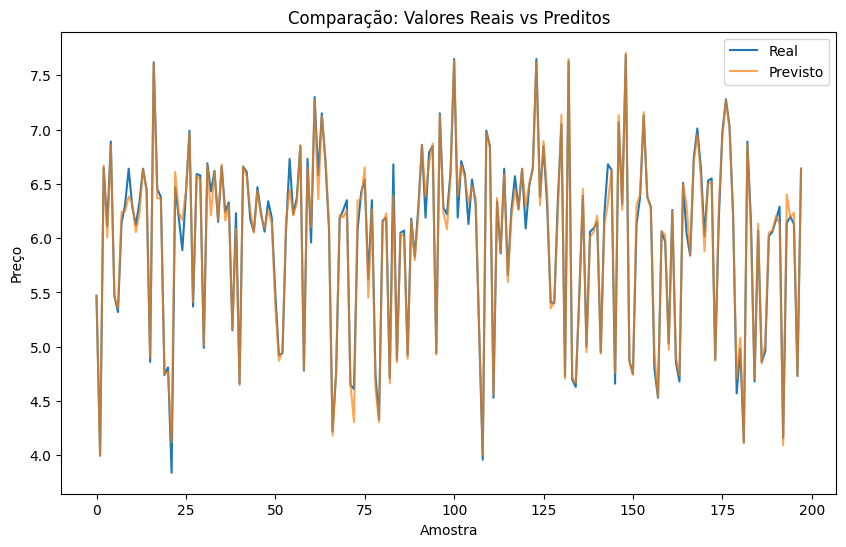

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='Real')
plt.plot(y_pred, label='Previsto', alpha=0.7)
plt.title('Comparação: Valores Reais vs Preditos')
plt.xlabel('Amostra')
plt.ylabel('Preço')
plt.legend()
plt.show()

In [15]:
import pandas as pd

df_comparacao = pd.DataFrame({
    'Real': y_test,
    'Previsto': y_pred
})

print(df_comparacao.head(50))  # mostra os 50 primeiros exemplos


      Real  Previsto
1352  5.47  5.468071
1667  4.00  3.993406
1137  6.65  6.667856
313   6.11  6.007944
1868  6.89  6.858114
1187  5.47  5.459038
9     5.32  5.358488
1728  6.14  6.242337
1962  6.31  6.246617
1036  6.64  6.384959
1805  6.29  6.320139
1711  6.12  6.056439
1973  6.33  6.221338
1887  6.64  6.634463
888   6.45  6.431375
1512  4.86  4.902596
74    7.62  7.611255
1385  6.45  6.367013
1877  6.38  6.367028
1343  4.74  4.750517
681   4.81  4.768120
1347  3.84  4.119905
729   6.47  6.609798
1374  6.19  6.234550
142   5.89  6.168970
1406  6.41  6.431375
1064  6.99  6.966716
12    5.37  5.412027
243   6.59  6.574069
213   6.58  6.537419
688   4.99  5.011983
1459  6.69  6.672960
889   6.43  6.209688
970   6.62  6.608711
914   6.15  6.165880
1538  6.66  6.677808
1411  6.24  6.163622
212   6.33  6.309034
176   5.15  5.156576
1233  6.23  6.088774
1186  4.66  4.646855
1864  6.66  6.659928
1870  6.61  6.572360
799   6.17  6.253371
1899  6.06  6.050406
1384  6.47  6.436381
1059  6.23  6

In [16]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

# Supondo que df_encoded seja seu DataFrame com dados já codificados
X = df_encoded.drop(columns=['PREÇO MÉDIO REVENDA'])  # substitua 'target' pelo nome correto da coluna alvo
y = df_encoded['PREÇO MÉDIO REVENDA']

# Definir modelo XGBoost
model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Definir esquema de validação cruzada (K-fold)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Rodar cross_val_score com RMSE negativo (scikit-learn usa "score" que é maior melhor, 
# então usamos scoring = 'neg_root_mean_squared_error' para RMSE)
scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=kfold)

# Converter scores para positivos e imprimir média e std
rmse_scores = -scores
print(f"RMSE médio: {rmse_scores.mean():.3f}")
print(f"Desvio padrão do RMSE: {rmse_scores.std():.3f}")


RMSE médio: 0.101
Desvio padrão do RMSE: 0.009
